# Linear Logistic Regression in NumPy

Fast logistic regression in NumPy with Conjugate Gradients from the SciPy optimize module.

In [1]:
import numpy as np
import scipy.optimize as spopt

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)

Some basic numerical functions, `cap_zero` takes values very close or equal to zero and makes them "tiny" non-zero values.  `softmax` computes the softmax along the last axis of a multi-axis array and `log_softmax` compute the natural log of the softmax along the last axis, in a way that is slightly faster and more numerically stable than computing the direct log of `softmax`.

In [2]:
def cap_zero(x, value=None):
    '''Return a copy of `x` where all values are capped at `value`,
    i.e., no values in the array are less than `value`.  If `value`
    is `None` (default) then the `np.finfo` `tiny` value is used
    for the `dtype` of `x`.
    '''
    if value is None:
        value = np.finfo(x.dtype).tiny
    x = x.copy()
    x[x < value] = value
    return x

def softmax(x):
    '''Compute the softmax of `x` along the last axis.'''
    mx = x.max(axis=-1)[..., None]                                                                  

    terms = np.exp(x - mx)
    denom = np.sum(terms, axis=-1)[..., None]

    return terms / cap_zero(denom)

def log_softmax(x):
    '''Compute the natural log of the softmax of `x` along the last axis.'''                        
    mx = x.max(axis=-1)[..., None]                                                                  
    xmx = x - mx                                                                                    
                                                                                                    
    terms = np.exp(xmx)                                                                             
    denom = np.sum(terms, axis=-1)[..., None]                                                       
    log_denom = np.log(cap_zero(denom))                                                             
                                                                                                    
    return xmx - log_denom

And now for the logistic regression implementation...

In [3]:
class LogisticRegression:
    '''Linear Logistic Regression.
    
    Inputs:
        x: np.array((..., ndim))
            The input features over which to perform a prediction.
            
    Outputs:
        logits: np.array((..., ncls))
            Predicted logit indicators for each class.  Higher values
            indicate a more confident prediction.  For predicted
            probabilities in (0,1), see the `.probs` method.
            For integer predicted class labels, see the `.labels` method.
    '''
    def __init__(self, ndim, ncls):
        '''Construct a new Linear Logistic Regression classifier.
        
        Args:
            ndim: int
                The number of input dimensions / features.
            ncls: int
                The number of classes in a prediction.
        '''
        self.ndim, self.ncls = ndim, ncls

        weight_scale = np.sqrt(3.0) / ndim
        self.weights = np.random.uniform(
            -weight_scale, weight_scale,
            size=(self.ndim+1, self.ncls))
        
    @property
    def parameters(self):
        '''Return a single flat NumPy array containing all of the
        parameters for this model.  Used for optimization with
        `scipy.optimize`.
        '''
        return self.weights.ravel()
        
    def __call__(self, x):
        '''Return predicted logits.'''
        assert x.ndim >= 2
        return x @ self.weights[:-1] + self.weights[-1]
    
    def probs(self, x):
        '''Return the predicted class membership probabilities.'''
        return softmax(self(x))
    
    def labels(self, x):
        '''Return the predicted class labels as integers.'''
        return np.argmax(self(x), axis=-1)
    
    def loss(self, x, g):
        '''Return the log loss, i.e., cross-entropy loss.'''
        likes = log_softmax(self(x))
        
        # pointwise multiplication of log likelihoods times target indicator
        # variables can be computed by simply selecting along the last axis
        likes_g = np.take_along_axis(likes, g[..., None], axis=-1)
        
        return -np.mean(likes_g)
    
    def grad(self, x, g):
        '''Return the gradient matrix using cross-entropy loss.
        This should be flattened for use with `scipy.optimize`.'''
        probs = softmax(self(x))

        delta = probs.reshape((-1, probs.shape[-1]))
        delta[range(delta.shape[0]), g.flat] -= 1.0
        
        x1 = np.concatenate((x, np.ones_like(x[..., 0])[..., None]), axis=-1)
        grad = x1.T.reshape((x1.shape[-1], -1)) @ delta
        
        return grad
    
    def train(self, x, g, precision=1.0e-6, method='cg', **options):
        '''Train this logistic regression model using `scipy.optimize.minimize`.
        The model is trained in place.
        
        Args:
            x: np.array(..., ndim)
                The training input data.
            g: np.array(...)
                Integer target class labels.
            precision: float
                The precision after which training will terminate.
            method: str
                The training method used by `scipy.optimize`.
                Defaults to `cg` conjugate gradients.
            **options:
                Additonal arguments to pass to `scipy.optimize.minimize`.
                
        Returns:
            dict
                A dictionary of result information returned by the
                `scipy.optimize.minimize` function.
        '''
        def loss_func(parameters):
            '''Set parameters on self and computes the log loss.'''
            self.parameters[...] = parameters
            return self.loss(x, g)
        
        def grad_func(parameters):
            '''Set parameters on self and compute the flattened gradient.'''
            self.parameters[...] = parameters
            return self.grad(x, g).ravel()
        
        # deligate minimization to scipy
        return spopt.minimize(
            fun=loss_func, method=method, x0=self.parameters,
            tol=precision, jac=grad_func, options=options)

A simple test with multi-axis arrays.  The last axis is for features, any earlier axes are additional observations, e.g., `number_of_sentences` x `number_of_words` x `word_embedding_size`.

In [4]:
inputs = np.random.random((4, 10, 32))
targets = np.array(inputs.sum(-1) < 0.5, dtype=np.int)

lr_model = LogisticRegression(32, 2)
opt_result = lr_model.train(inputs, targets)
print(opt_result)

logits = lr_model(inputs)
probs = lr_model.probs(inputs)
labels = lr_model.labels(inputs)
loss = lr_model.loss(inputs, targets)
grad = lr_model.grad(inputs, targets)

print('logits:', logits.shape)
print('probs:', probs.shape)
print('labels:', labels.shape)
print('loss:', loss)

     fun: 6.729628812388163e-09
     jac: array([-1.0124e-07,  1.0124e-07, -1.5744e-07,  1.5744e-07, -1.3463e-07,
        1.3463e-07, -8.7313e-08,  8.7313e-08, -1.5306e-07,  1.5306e-07,
       -1.2291e-07,  1.2291e-07, -1.3423e-07,  1.3423e-07, -1.5360e-07,
        1.5360e-07, -7.5299e-08,  7.5299e-08, -9.1087e-08,  9.1087e-08,
       -1.3183e-07,  1.3183e-07, -1.4538e-07,  1.4538e-07, -1.1170e-07,
        1.1170e-07, -8.8735e-08,  8.8735e-08, -1.1562e-07,  1.1562e-07,
       -1.4294e-07,  1.4294e-07, -1.8316e-07,  1.8316e-07, -1.8856e-07,
        1.8856e-07, -1.9017e-07,  1.9017e-07, -1.3902e-07,  1.3902e-07,
       -1.1815e-07,  1.1815e-07, -9.7933e-08,  9.7933e-08, -1.3428e-07,
        1.3428e-07, -9.5068e-08,  9.5068e-08, -1.6143e-07,  1.6143e-07,
       -1.2535e-07,  1.2535e-07, -1.2863e-07,  1.2863e-07, -1.2580e-07,
        1.2580e-07, -1.4985e-07,  1.4985e-07, -1.3444e-07,  1.3444e-07,
       -9.5103e-08,  9.5103e-08, -1.0947e-07,  1.0947e-07, -2.6919e-07,
        2.6919e-07])
 

Conjugate gradients documentation below.  CG should be able to solve in number of inputs iterations (plus a few for numerical precision).  Note that there may be multiple function and gradient evaluations for each iteration, each iteration corresponds to a search direction but still have to optimize along each direction.

In [5]:
#spopt.fmin_cg?

A 1D example with three classes, shows that it works!!

     fun: 0.06566119080554075
     jac: array([ 1.1133, -1.0993, -0.0141, -0.7264,  0.1459,  0.5804])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 39
     nit: 10
    njev: 39
  status: 1
 success: False
       x: array([-8.9186, -0.3822,  7.8608, -2.2563,  2.8018, -1.3952])
c1:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
c2:
[0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
c3:
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


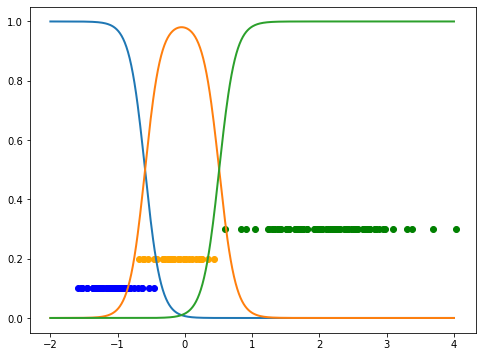

In [6]:
c1 = np.random.normal(loc=-1.0, scale=0.3, size=(60, 1))
c2 = np.random.normal(loc=0.0, scale=0.3, size=(30, 1))
c3 = np.random.normal(loc=2.0, scale=0.7, size=(90, 1))
inputs = np.concatenate((c1, c2, c3), axis=0)
targets = np.array([0,]*c1.size + [1,]*c2.size + [2,]*c3.size)

model = LogisticRegression(1, 3)
opt_result = model.train(inputs, targets, method='cg', maxiter=10)
print(opt_result)
                                                                                                    
c1_probs = model.probs(c1)                                                                       
c2_probs = model.probs(c2)                                                                       
c3_probs = model.probs(c3)                                                                       
                                                                                                    
print("c1:")                                                                                    
print(model.labels(c1))                                                                          
print("c2:")                                                                                    
print(model.labels(c2))                                                                          
print("c3:")                                                                                    
print(model.labels(c3))                                                                          
                                                                                                    
x = np.linspace(-2.0, 4.0, 500)[:, None]
x_probs = model.probs(x)                                                                         
                                                                                                    
plt.plot(x, x_probs, linewidth=2)
plt.scatter(c1, np.zeros_like(c1) + 0.1, color='blue');
plt.scatter(c2, np.zeros_like(c2) + 0.2, color='orange');
plt.scatter(c3, np.zeros_like(c3) + 0.3, color='green');

In [7]:
# covariance matrix for each training class
cov = [[1, -0.8],
       [-0.8, 1]]

# red data
red = np.random.multivariate_normal((-1, -1), cov, 500)

# green data
green = np.random.multivariate_normal((0, 0), cov, 300)

# blue data
blue = np.random.multivariate_normal((1, 1), cov, 400)

inputs = np.vstack((red, green, blue))
targets = np.array(([0,]*red.shape[0] + [1,]*green.shape[0] + [2,]*blue.shape[0]))

# min and max training values                                                                   
mn = np.min(inputs, axis=0)
mx = np.max(inputs, axis=0)

# train model
model2 = LogisticRegression(2, 3)
opt_result = model2.train(inputs, targets)

print('optimization result:')
print(opt_result)

# find class labels
red_labels = model2.labels(red)
green_labels = model2.labels(green)                                                                 
blue_labels = model2.labels(blue)                                                                   
                                                                                                    
print("\nred labels:")
print(red_labels)                                                                                 
print("\ngreen labels:")
print(green_labels)                                                                               
print("\nblue labels:")
print(blue_labels)

optimization result:
     fun: 0.15482595300432628
     jac: array([-3.5653e-06,  3.6270e-07,  3.2026e-06, -3.2515e-06, -1.4508e-07,
        3.3966e-06,  3.5477e-06, -2.6454e-06, -9.0227e-07])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 416
     nit: 61
    njev: 405
  status: 2
 success: False
       x: array([-4.8174,  0.4999,  6.1825, -5.2759, -0.2265,  5.3389, -1.077 ,
        3.4362, -2.3989])

red labels:
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0

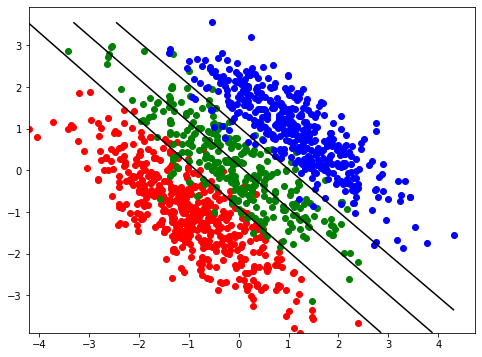

In [8]:
# first figure shows training data and class intersections
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# training data
ax.scatter(red[:,0],   red[:,1],   color='red')
ax.scatter(green[:,0], green[:,1], color='green')
ax.scatter(blue[:,0],  blue[:,1],  color='blue')

# generate grid over training data
sw = 0.02
sx = np.arange(mn[0], mx[0], sw)
sy = np.arange(mn[1], mx[1], sw)
x, y = np.meshgrid(sx, sy, copy=False)

# get probability densities and labels for values in grid
z = np.vstack((x.reshape((-1,)), y.reshape((-1,)))).T
probs = model2.probs(z)

# red, green, blue and max probability densities
redp = np.reshape(probs[:,0,None], x.shape)
greenp = np.reshape(probs[:,1,None], x.shape)
bluep = np.reshape(probs[:,2,None], x.shape)
maxp = np.reshape(np.max(probs, axis=1), x.shape)

# class intersections
diff_rg = redp   - greenp
diff_rb = redp   - bluep
diff_gb = greenp - bluep
ax.contour(x, y, diff_rg, colors="black", levels=(0,));
ax.contour(x, y, diff_rb, colors="black", levels=(0,));
ax.contour(x, y, diff_gb, colors="black", levels=(0,));

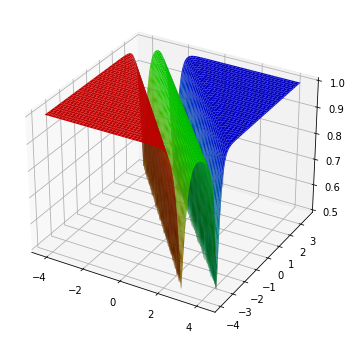

In [9]:
# second figure shows 3d plots of probability densities
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

# straight class colors for suface plots
color = np.reshape((redp, greenp, bluep), (3, x.shape[0], x.shape[1]))
color = color.swapaxes(1, 2).T

# flip colors to fade to white
zro = np.zeros_like(x)
color_flip = np.ones((3, x.shape[0], x.shape[1]))
color_flip -= (
    np.array((zro, redp, redp)) +
    np.array((greenp, zro, greenp)) +
    np.array((bluep, bluep, zro))
)
color_flip -= np.min(color_flip)
color_flip /= np.max(color_flip)
color_flip = color_flip.swapaxes(1, 2).T

# probability density surface
surf = ax.plot_surface(x, y, maxp, facecolors=color_flip,
                       linewidth=0.02, shade=True)

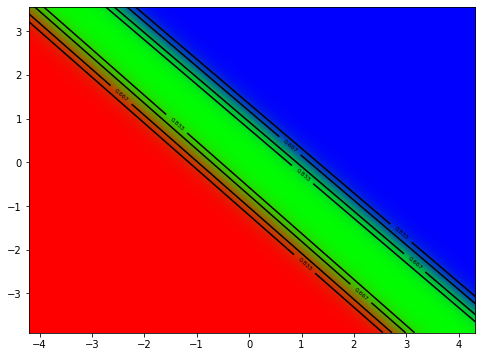

In [10]:
# third figure shows contours and color image of probability densities
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

#ax.pcolor(x, y, pMax)
ax.imshow(color_flip, origin='lower',
          extent=(mn[0], mx[0], mn[1], mx[1]), aspect='auto')

# contours
nlevel = 4
cs = ax.contour(x, y, maxp, colors='black',
                levels=np.linspace(np.min(maxp), np.max(maxp), nlevel));
cs.clabel(fontsize=6);

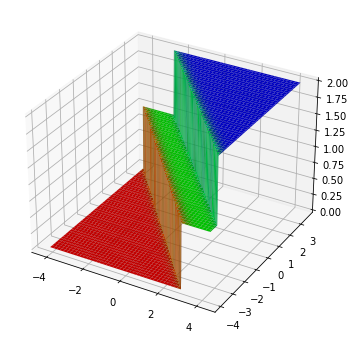

In [11]:
# fourth figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

labels = model2.labels(z)
lmax = np.reshape(labels, x.shape)

surf = ax.plot_surface(x, y, lmax, facecolors=color_flip, linewidth=0.02)
surf.set_edgecolor('black')

Just some tinkering around with NumPy indexing... I'll delete this once I'm sure it's how I want it above.

In [12]:
a = np.random.random((10, 12))
b = np.random.random(10*12)

a.flat[...] = b

a, b

(array([[0.3805, 0.2012, 0.9344, 0.6064, 0.9875, 0.5511, 0.3827, 0.8643,
         0.7765, 0.7478, 0.547 , 0.8313],
        [0.7996, 0.292 , 0.9412, 0.2926, 0.3727, 0.5502, 0.2654, 0.6625,
         0.4628, 0.3418, 0.2659, 0.4359],
        [0.7992, 0.7629, 0.3596, 0.4475, 0.7653, 0.4013, 0.3855, 0.1445,
         0.2526, 0.2898, 0.6256, 0.3968],
        [0.9636, 0.3234, 0.7646, 0.6953, 0.5621, 0.4479, 0.5093, 0.2041,
         0.8664, 0.5876, 0.0111, 0.7059],
        [0.0586, 0.7994, 0.6417, 0.2134, 0.166 , 0.772 , 0.2714, 0.2977,
         0.0986, 0.2187, 0.4379, 0.098 ],
        [0.3755, 0.9004, 0.0856, 0.8496, 0.6876, 0.4297, 0.6947, 0.4693,
         0.1894, 0.1814, 0.6545, 0.6307],
        [0.7886, 0.1913, 0.812 , 0.8525, 0.8261, 0.5551, 0.3754, 0.055 ,
         0.364 , 0.8732, 0.5135, 0.5261],
        [0.2394, 0.3821, 0.3858, 0.3261, 0.7147, 0.6087, 0.2274, 0.8307,
         0.6128, 0.1499, 0.5753, 0.2846],
        [0.8568, 0.4885, 0.8513, 0.426 , 0.8881, 0.7422, 0.9812, 0.3174,
       

In [13]:
a = np.random.random((2, 4, 3))
g = np.array([0, 0, 2, 1])
a.shape, a[..., range(a.shape[1]), g].shape
a, a[..., range(a.shape[-2]), g]

(array([[[0.6512, 0.1872, 0.2698],
         [0.3378, 0.3101, 0.9362],
         [0.6642, 0.4132, 0.0602],
         [0.3373, 0.9651, 0.2599]],
 
        [[0.7095, 0.2284, 0.4033],
         [0.4564, 0.6977, 0.4956],
         [0.9113, 0.2599, 0.8519],
         [0.4891, 0.9105, 0.8213]]]),
 array([[0.6512, 0.3378, 0.0602, 0.9651],
        [0.7095, 0.4564, 0.8519, 0.9105]]))

In [14]:
a = np.random.random((4, 3))
g = np.array([0, 0, 2, 1])
print(g, g.shape)
print(a, a.shape)
print(a[range(a.shape[0]), g], a[range(a.shape[0]), g].shape)

[0 0 2 1] (4,)
[[0.693  0.1621 0.3828]
 [0.3039 0.2456 0.4396]
 [0.4837 0.2913 0.2562]
 [0.8184 0.1755 0.2059]] (4, 3)
[0.693  0.3039 0.2562 0.1755] (4,)


In [15]:
a = np.random.random((2, 4, 3))
g = np.array([[0, 0, 2, 1], [0, 0, 1, 2]])
rows, cols = np.indices(a.shape[:-1])
a, a[rows, cols, g]

(array([[[0.1781, 0.8058, 0.7518],
         [0.941 , 0.9064, 0.4975],
         [0.2115, 0.8055, 0.239 ],
         [0.5692, 0.4051, 0.5544]],
 
        [[0.2632, 0.3587, 0.7637],
         [0.8323, 0.5177, 0.4634],
         [0.1406, 0.1489, 0.6555],
         [0.4604, 0.6614, 0.7941]]]),
 array([[0.1781, 0.941 , 0.239 , 0.4051],
        [0.2632, 0.8323, 0.1489, 0.7941]]))

In [16]:
a = np.random.random((4, 3))
g = np.array([0, 0, 2, 1])[:, None]
a, np.take_along_axis(a, g, axis=-1)

(array([[0.7166, 0.5446, 0.3087],
        [0.9109, 0.3498, 0.1198],
        [0.8102, 0.0243, 0.8789],
        [0.9529, 0.6404, 0.6703]]),
 array([[0.7166],
        [0.9109],
        [0.8789],
        [0.6404]]))

In [17]:
a = np.random.random((2, 4, 3))
g = np.array([[0, 0, 2, 1], [0, 0, 1, 2]])[..., None]
a, np.take_along_axis(a, g, axis=-1)

(array([[[0.7518, 0.6985, 0.0248],
         [0.5206, 0.264 , 0.2813],
         [0.2761, 0.4818, 0.2054],
         [0.8686, 0.4837, 0.3206]],
 
        [[0.4079, 0.9225, 0.5558],
         [0.6009, 0.7938, 0.1858],
         [0.7295, 0.2282, 0.617 ],
         [0.8148, 0.7668, 0.6583]]]),
 array([[[0.7518],
         [0.5206],
         [0.2054],
         [0.4837]],
 
        [[0.4079],
         [0.6009],
         [0.2282],
         [0.6583]]]))

In [18]:
a = np.random.random((2, 4, 3))
g = np.array([[0, 0, 2, 1], [0, 0, 1, 2]])

a, a.reshape((-1, a.shape[-1]))[range(2*4), g.flat].reshape(g.shape)

(array([[[0.132 , 0.7902, 0.4635],
         [0.2396, 0.2564, 0.3399],
         [0.0378, 0.1059, 0.6993],
         [0.5585, 0.1239, 0.8206]],
 
        [[0.1567, 0.1606, 0.7604],
         [0.291 , 0.3201, 0.048 ],
         [0.9073, 0.0105, 0.972 ],
         [0.7051, 0.4298, 0.8113]]]),
 array([[0.132 , 0.2396, 0.6993, 0.1239],
        [0.1567, 0.291 , 0.0105, 0.8113]]))

In [19]:
a = np.random.random((2, 4))
g = np.array([0, 1])

a, np.take_along_axis(a, g[:, None], axis=-1)
a, a[range(a.shape[0]), g]

(array([[0.2854, 0.8641, 0.7295, 0.9569],
        [0.7425, 0.0791, 0.1534, 0.6438]]),
 array([0.2854, 0.0791]))

In [20]:
(3,) * 4

(3, 3, 3, 3)